# Loss Plot of CNN model

This notebook is used to plot the loss curve of CNN model in training process. Please check the end of this notebook for the result.

In [23]:
from datasets import load_dataset
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [24]:
emotions = load_dataset("dair-ai/emotion")

In [25]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [26]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

In [27]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)

In [28]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: dict, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data["text"], data["label"]):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

In [29]:
train_instances = preprocess(train_data, tokenizer)
val_instances = preprocess(validation_data, tokenizer)
test_instances = preprocess(test_data, tokenizer)

In [30]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [31]:

train_losses = []
val_losses = []


In [32]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(50, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(x)

        return y
    
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        self.val_score = []
        self.train_losses = []
        self.val_losses = []

        for epoch in range(epochs):
            train_batches = batching(train_instances, batch_size=batch_size, shuffle=True)
            epoch_train_loss = 0.0
            total_train_samples = 0

            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * inputs.size(0)
                total_train_samples += inputs.size(0)

            avg_train_loss = epoch_train_loss / total_train_samples
            self.train_losses.append(avg_train_loss)

            # Evaluate on validation set
            self.eval()
            val_batches = batching(val_instances, batch_size=batch_size, shuffle=False)
            epoch_val_loss = 0.0
            total_val_samples = 0

            with torch.no_grad():
                for inputs, labels in val_batches:
                    outputs = self(inputs)
                    loss = nn.functional.cross_entropy(outputs, labels)
                    epoch_val_loss += loss.item() * inputs.size(0)
                    total_val_samples += inputs.size(0)

            avg_val_loss = epoch_val_loss / total_val_samples
            self.val_losses.append(avg_val_loss)

            train_f1 = self.evaluate2(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate2(val_instances, batch_size=batch_size)
            self.val_score.append(val_f1)

            print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")
    
    def evaluate2(self, instances, batch_size):
        """ 
        To make evaluations against the gold standard (true labels) from the 
        data.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        true = []
        pred = []

        for inputs, labels in batches:
            true.extend(labels)
            pred.extend(self.predict(inputs))

        return f1_score(true, pred, average="macro")

In [20]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=50, batch_size=16)

100%|██████████| 1000/1000 [00:04<00:00, 202.22it/s]


Epoch 1 | Train Loss: 1.2146 | Val Loss: 0.6823 | Train F1: 0.6445 | Val F1: 0.5897


100%|██████████| 1000/1000 [00:04<00:00, 215.85it/s]


Epoch 2 | Train Loss: 0.3849 | Val Loss: 0.3351 | Train F1: 0.9228 | Val F1: 0.8434


100%|██████████| 1000/1000 [00:04<00:00, 213.96it/s]


Epoch 3 | Train Loss: 0.1536 | Val Loss: 0.3305 | Train F1: 0.9572 | Val F1: 0.8553


100%|██████████| 1000/1000 [00:05<00:00, 195.55it/s]


Epoch 4 | Train Loss: 0.0819 | Val Loss: 0.3800 | Train F1: 0.9774 | Val F1: 0.8510


100%|██████████| 1000/1000 [00:04<00:00, 210.36it/s]


Epoch 5 | Train Loss: 0.0498 | Val Loss: 0.3963 | Train F1: 0.9843 | Val F1: 0.8659


100%|██████████| 1000/1000 [00:04<00:00, 208.21it/s]


Epoch 6 | Train Loss: 0.0427 | Val Loss: 0.4259 | Train F1: 0.9858 | Val F1: 0.8547


100%|██████████| 1000/1000 [00:04<00:00, 200.19it/s]


Epoch 7 | Train Loss: 0.0421 | Val Loss: 0.4344 | Train F1: 0.9886 | Val F1: 0.8675


100%|██████████| 1000/1000 [00:04<00:00, 210.28it/s]


Epoch 8 | Train Loss: 0.0321 | Val Loss: 0.4637 | Train F1: 0.9911 | Val F1: 0.8621


100%|██████████| 1000/1000 [00:05<00:00, 188.48it/s]


Epoch 9 | Train Loss: 0.0277 | Val Loss: 0.4932 | Train F1: 0.9942 | Val F1: 0.8639


100%|██████████| 1000/1000 [00:05<00:00, 181.97it/s]


Epoch 10 | Train Loss: 0.0273 | Val Loss: 0.4949 | Train F1: 0.9936 | Val F1: 0.8635


100%|██████████| 1000/1000 [00:05<00:00, 196.92it/s]


Epoch 11 | Train Loss: 0.0239 | Val Loss: 0.5220 | Train F1: 0.9902 | Val F1: 0.8601


100%|██████████| 1000/1000 [00:04<00:00, 213.35it/s]


Epoch 12 | Train Loss: 0.0243 | Val Loss: 0.6494 | Train F1: 0.9910 | Val F1: 0.8492


100%|██████████| 1000/1000 [00:04<00:00, 207.42it/s]


Epoch 13 | Train Loss: 0.0178 | Val Loss: 0.5695 | Train F1: 0.9933 | Val F1: 0.8638


100%|██████████| 1000/1000 [00:04<00:00, 200.78it/s]


Epoch 14 | Train Loss: 0.0177 | Val Loss: 0.5838 | Train F1: 0.9934 | Val F1: 0.8607


100%|██████████| 1000/1000 [00:04<00:00, 208.73it/s]


Epoch 15 | Train Loss: 0.0233 | Val Loss: 0.5426 | Train F1: 0.9904 | Val F1: 0.8571


100%|██████████| 1000/1000 [00:04<00:00, 205.12it/s]


Epoch 16 | Train Loss: 0.0191 | Val Loss: 0.5537 | Train F1: 0.9957 | Val F1: 0.8799


100%|██████████| 1000/1000 [00:04<00:00, 207.15it/s]


Epoch 17 | Train Loss: 0.0170 | Val Loss: 0.6142 | Train F1: 0.9937 | Val F1: 0.8652


100%|██████████| 1000/1000 [00:04<00:00, 210.05it/s]


Epoch 18 | Train Loss: 0.0170 | Val Loss: 0.6632 | Train F1: 0.9951 | Val F1: 0.8613


100%|██████████| 1000/1000 [00:04<00:00, 208.72it/s]


Epoch 19 | Train Loss: 0.0136 | Val Loss: 0.6036 | Train F1: 0.9964 | Val F1: 0.8719


100%|██████████| 1000/1000 [00:04<00:00, 201.35it/s]


Epoch 20 | Train Loss: 0.0097 | Val Loss: 0.6462 | Train F1: 0.9949 | Val F1: 0.8662


100%|██████████| 1000/1000 [00:04<00:00, 212.67it/s]


Epoch 21 | Train Loss: 0.0140 | Val Loss: 0.7205 | Train F1: 0.9938 | Val F1: 0.8686


100%|██████████| 1000/1000 [00:04<00:00, 210.14it/s]


Epoch 22 | Train Loss: 0.0175 | Val Loss: 0.7073 | Train F1: 0.9959 | Val F1: 0.8688


100%|██████████| 1000/1000 [00:04<00:00, 219.81it/s]


Epoch 23 | Train Loss: 0.0122 | Val Loss: 0.7795 | Train F1: 0.9940 | Val F1: 0.8635


100%|██████████| 1000/1000 [00:04<00:00, 210.31it/s]


Epoch 24 | Train Loss: 0.0113 | Val Loss: 0.6454 | Train F1: 0.9956 | Val F1: 0.8770


100%|██████████| 1000/1000 [00:04<00:00, 208.56it/s]


Epoch 25 | Train Loss: 0.0087 | Val Loss: 0.6703 | Train F1: 0.9964 | Val F1: 0.8683


100%|██████████| 1000/1000 [00:05<00:00, 185.89it/s]


Epoch 26 | Train Loss: 0.0071 | Val Loss: 0.7828 | Train F1: 0.9964 | Val F1: 0.8759


100%|██████████| 1000/1000 [00:04<00:00, 201.52it/s]


Epoch 27 | Train Loss: 0.0208 | Val Loss: 0.8402 | Train F1: 0.9947 | Val F1: 0.8654


100%|██████████| 1000/1000 [00:04<00:00, 216.94it/s]


Epoch 28 | Train Loss: 0.0101 | Val Loss: 0.7793 | Train F1: 0.9956 | Val F1: 0.8642


100%|██████████| 1000/1000 [00:04<00:00, 213.23it/s]


Epoch 29 | Train Loss: 0.0081 | Val Loss: 0.7585 | Train F1: 0.9961 | Val F1: 0.8585


100%|██████████| 1000/1000 [00:04<00:00, 219.40it/s]


Epoch 30 | Train Loss: 0.0072 | Val Loss: 0.7953 | Train F1: 0.9966 | Val F1: 0.8641


100%|██████████| 1000/1000 [00:05<00:00, 197.28it/s]


Epoch 31 | Train Loss: 0.0063 | Val Loss: 0.9025 | Train F1: 0.9934 | Val F1: 0.8547


100%|██████████| 1000/1000 [00:04<00:00, 200.54it/s]


Epoch 32 | Train Loss: 0.0119 | Val Loss: 0.8367 | Train F1: 0.9952 | Val F1: 0.8573


100%|██████████| 1000/1000 [00:05<00:00, 195.08it/s]


Epoch 33 | Train Loss: 0.0122 | Val Loss: 0.8442 | Train F1: 0.9951 | Val F1: 0.8638


100%|██████████| 1000/1000 [00:05<00:00, 195.77it/s]


Epoch 34 | Train Loss: 0.0087 | Val Loss: 0.8257 | Train F1: 0.9945 | Val F1: 0.8556


100%|██████████| 1000/1000 [00:05<00:00, 192.81it/s]


Epoch 35 | Train Loss: 0.0081 | Val Loss: 1.0499 | Train F1: 0.9925 | Val F1: 0.8507


100%|██████████| 1000/1000 [00:05<00:00, 198.92it/s]


Epoch 36 | Train Loss: 0.0083 | Val Loss: 0.9129 | Train F1: 0.9965 | Val F1: 0.8686


100%|██████████| 1000/1000 [00:05<00:00, 194.02it/s]


Epoch 37 | Train Loss: 0.0059 | Val Loss: 0.8723 | Train F1: 0.9969 | Val F1: 0.8666


100%|██████████| 1000/1000 [00:04<00:00, 216.83it/s]


Epoch 38 | Train Loss: 0.0106 | Val Loss: 0.8993 | Train F1: 0.9953 | Val F1: 0.8702


100%|██████████| 1000/1000 [00:04<00:00, 212.97it/s]


Epoch 39 | Train Loss: 0.0087 | Val Loss: 0.8919 | Train F1: 0.9966 | Val F1: 0.8648


100%|██████████| 1000/1000 [00:04<00:00, 212.65it/s]


Epoch 40 | Train Loss: 0.0057 | Val Loss: 0.9348 | Train F1: 0.9967 | Val F1: 0.8656


100%|██████████| 1000/1000 [00:04<00:00, 208.87it/s]


Epoch 41 | Train Loss: 0.0062 | Val Loss: 0.9754 | Train F1: 0.9947 | Val F1: 0.8671


100%|██████████| 1000/1000 [00:05<00:00, 192.94it/s]


Epoch 42 | Train Loss: 0.0157 | Val Loss: 0.9263 | Train F1: 0.9958 | Val F1: 0.8777


100%|██████████| 1000/1000 [00:05<00:00, 191.92it/s]


Epoch 43 | Train Loss: 0.0087 | Val Loss: 1.1563 | Train F1: 0.9958 | Val F1: 0.8677


100%|██████████| 1000/1000 [00:04<00:00, 214.23it/s]


Epoch 44 | Train Loss: 0.0058 | Val Loss: 0.9574 | Train F1: 0.9965 | Val F1: 0.8732


100%|██████████| 1000/1000 [00:04<00:00, 208.86it/s]


Epoch 45 | Train Loss: 0.0039 | Val Loss: 0.9474 | Train F1: 0.9970 | Val F1: 0.8793


100%|██████████| 1000/1000 [00:04<00:00, 210.25it/s]


Epoch 46 | Train Loss: 0.0036 | Val Loss: 0.8854 | Train F1: 0.9953 | Val F1: 0.8639


100%|██████████| 1000/1000 [00:04<00:00, 209.99it/s]


Epoch 47 | Train Loss: 0.0157 | Val Loss: 1.2132 | Train F1: 0.9904 | Val F1: 0.8638


100%|██████████| 1000/1000 [00:04<00:00, 206.81it/s]


Epoch 48 | Train Loss: 0.0084 | Val Loss: 1.0531 | Train F1: 0.9966 | Val F1: 0.8760


100%|██████████| 1000/1000 [00:05<00:00, 195.48it/s]


Epoch 49 | Train Loss: 0.0042 | Val Loss: 0.9926 | Train F1: 0.9969 | Val F1: 0.8784


100%|██████████| 1000/1000 [00:04<00:00, 222.47it/s]


Epoch 50 | Train Loss: 0.0033 | Val Loss: 0.9930 | Train F1: 0.9970 | Val F1: 0.8718


In [21]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.895
Precision: 0.8511103633095537
Recall: 0.843470948763024
F1 Score: 0.8469735512183125
Confusion Matrix:
[[548   8   3  16   5   1]
 [  7 640  33   8   5   2]
 [  3  31 119   3   2   1]
 [ 15   8   2 241   9   0]
 [  6   2   0  10 196  10]
 [  3   2   0   4  11  46]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       581
           1       0.93      0.92      0.92       695
           2       0.76      0.75      0.75       159
           3       0.85      0.88      0.87       275
           4       0.86      0.88      0.87       224
           5       0.77      0.70      0.73        66

    accuracy                           0.90      2000
   macro avg       0.85      0.84      0.85      2000
weighted avg       0.89      0.90      0.89      2000



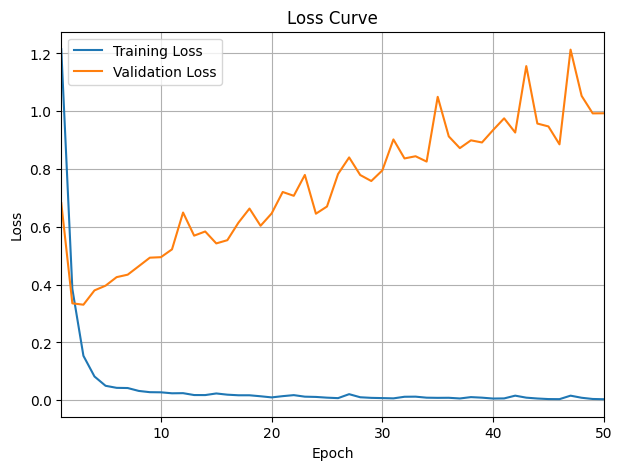

In [22]:
# === Plot Training and Validation Loss ===

plt.figure(figsize=(7, 5))
x_values = np.arange(1, len(classifier.train_losses) + 1)
plt.plot(x_values, classifier.train_losses, label='Training Loss')
plt.plot(x_values, classifier.val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.xlim(1, 50)
plt.legend()
plt.grid(True)
plt.show()

As the plot shows, the validation loss starting to rise in a steep slope after around 5th epoch, which is pretty early. After research, we speculate it is because of the size of the dataset: most neural network models are capable for much larger datasets, including the CNN model. With our dataset which is relatively compact, our CNN model can easily detect and learn features within several epochs of training, and starts to be overfitted in the later epochs.